## 1. Introduction

In this notebook, we investigate the effect of label granularity on Arabic dialect classification. 
Specifically, we compare performance between:

- 11k samples per **country-level** label
- 11k samples per **region-level** label

We train and evaluate multiple models including:
- Logistic Regression 
- SVM
- XGBOOST
- AraBERT

---


## 2. Dataset Preparation

We use 'data_v0.1.0.csv' is a collection of Arabic sentences and their corresponding dialect labels, The dataset was constructed by combining data from multiple sources:
## Arabic Dialect Datasets

| Name | Source | Paper |
|------|--------|-------|
| **arabic_pos_dialect** | [Hugging Face](https://huggingface.co/datasets/arabic_pos_dialect) | — |
| **IADD: An integrated Arabic dialect identification dataset** | [GitHub](https://github.com/JihadZa/IADD) | [Paper (Elsevier)](https://www.sciencedirect.com/science/article/pii/S2352340921010519) |
| **QADI: Arabic Dialect Identification in the Wild** | [GitHub](https://github.com/qcri/QADI) | [ResearchGate](https://www.researchgate.net/publication/341396032_Arabic_Dialect_Identification_in_the_Wild) |
| **The MADAR Arabic Dialect Corpus and Lexicon** | [Official Site](https://sites.google.com/nyu.edu/madar/?pli=1) | [ACL Paper](https://aclanthology.org/L18-1535.pdf) |
**10,000 sentences in Modern Standard Arabic (MSA) from Wikipedia**

[GitHub: Arabic Dialect Identification (credits)](https://github.com/Lafifi-24/arabic-dialect-identification/tree/main)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv("data_v0.1.0.csv")

df.head

<bound method NDFrame.head of                                                      text dialect
0       ياخي المدرب أختاره والمدرب دخله والمدرب بارك ا...      AE
1       شو الي قاعد يجري فالنصر يا أخوه خسر المباراة س...      AE
2             الي يبحث عن مشكلة الوصل راح يحصلها فالجولان      AE
3       انا مش معترض على تغير عامر الي دخل مكان عامر ا...      AE
4       تراجع مخيف في مستوى الحارس الكبير ماجد ناصر مش...      AE
...                                                   ...     ...
365714                 هل لك أن تسمح بالتقاط صورة لك معنا     MSA
365715                                   هل لديك سمك مقلي     MSA
365716        هل يمكني استئجار مرشدا يتحدث الغة اليابانية     MSA
365717  أيهما تعتقد أنها أفضل كهدية لصبي عمره ثماني سنوات     MSA
365718                               تعني في نطاق المدينة     MSA

[365719 rows x 2 columns]>

### Data Modification 

#### Initial Dataset Distribution by Country
| Country | Samples |
|---------|---------|
| AE      | 20,000  |
| BH      | 20,000  |
| DZ      | 20,000  |
| EG      | 20,000  |
| IQ      | 20,000  |
| JO      | 20,000  |
| KW      | 20,000  |
| LB      | 20,000  |
| LY      | 20,000  |
| MA      | 20,000  |
| OM      | 20,000  |
| PL      | 20,000  |
| QA      | 20,000  |
| SA      | 20,000  |
| SY      | 20,000  |
| MSA     | 20,000  |
| TN      | 20,000  |
| SD      | 14,481  |
| YE      | 11,238  |

#### Test 1: Country-Level Sampling
Limit **each country** to 11,000 sentences, then group countries into regions:

- **GULF** (6 countries): AE, BH, QA, KW, OM, SA  
- **NA** (4 countries): DZ, LY, MA, TN  
- **LEV** (4 countries): SY, LB, JO, PL  
- **NILE** (2 countries): EG, SD  
- **IRAQ** (1 country): IQ  
- **YEM** (1 country): YE  
- **MSA**: Treated as its own group (1 country)

This yields a **fine-grained** sampling followed by region grouping.

#### Test 2: Region-Level Sampling
Limit **each region** to **11,000 sentences**, regardless of how many countries are in each.

This creates a **balanced dataset** across 7 regions:
- GULF, NA, LEV, NILE, IRAQ, YEM, and MSA

In [8]:
# Test 1
# df_country_sampled = Each country is limited to 11,000 sentences
df_country_sampled = df.groupby("dialect",group_keys=False).apply(lambda x: x.sample(n=11000, random_state=42))

arabic_dialects = {
    "AE" : "GULF", 
    "BH" : "GULF",
    "DZ" : "NA", 
    "EG" : "NILE",
    "IQ" : "IRAQ",
    "JO" : "LEV",
    "KW" : "GULF",
    "LB" : "LEV",
    "LY" : "NA",
    "MA" : "NA", 
    "OM" : "GULF",
    "PL" : "LEV", 
    "QA" : "GULF",
    "SA" : "GULF",
    "SD" : "NILE", 
    "SY" :  "LEV",
    "TN" : "NA",
    "YE" : "YEM",
    "MSA" : "MSA"
}
#for dialect in arabic_dialects:
df_country_sampled["Region"] = df_country_sampled["dialect"].map(arabic_dialects)
df_country_sampled["Region"].value_counts()

df_country_sampled.to_csv("df_country_sampled.csv", index=False)

C:\Users\essah\AppData\Local\Temp\ipykernel_18908\2663422867.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_country_sampled = df.groupby("dialect",group_keys=False).apply(lambda x: x.sample(n=11000, random_state=42))


In [9]:
# Test 2: Each Region is limited to 11,000 sentences
df_region_sampled = df_country_sampled.groupby('Region', group_keys=False).apply(lambda x: x.sample(n=11000, random_state=42)).reset_index(drop=True)
df_region_sampled["Region"].value_counts()

df_region_sampled.to_csv("df_region_sampled.csv", index=False)

C:\Users\essah\AppData\Local\Temp\ipykernel_18908\4192966630.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_region_sampled = df_country_sampled.groupby('Region', group_keys=False).apply(lambda x: x.sample(n=11000, random_state=42)).reset_index(drop=True)


## Splitting the Dataset into Training and testing

The split will be as follows:
- Training Dataset 80%
- Testing Dataset 20%

In [10]:
x1 , y1 = df_country_sampled["text"] , df_country_sampled["Region"]
x2 , y2 = df_region_sampled["text"] , df_region_sampled["Region"]

x1_train , x1_test , y1_train , y1_test = train_test_split(x1 , y1 , test_size=0.2, stratify=y1, random_state=42)
x2_train , x2_test , y2_train , y2_test = train_test_split(x2 , y2 , test_size=0.2, stratify=y2, random_state=42)

# MODEL 1: TF-IDF + Logistic Regression

## TF-IDF vetorization (test 1)

In [11]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), analyzer='char_wb')
X_train_tfidf = vectorizer.fit_transform(x1_train)
X_test_tfidf = vectorizer.transform(x1_test)

### Training the Logical Regression Model

In [12]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y1_train)

LogisticRegression(max_iter=1000)

In [13]:
y_pred = lr_model.predict(X_test_tfidf)

print("TF-IDF + Logistic Regression Classification Report:\n")
print(classification_report(y1_test, y_pred))


TF-IDF + Logistic Regression Classification Report:

              precision    recall  f1-score   support

        GULF       0.56      0.77      0.65     13200
        IRAQ       0.60      0.22      0.32      2200
         LEV       0.56      0.56      0.56      8800
         MSA       0.79      0.83      0.81      2200
          NA       0.59      0.58      0.58      8800
        NILE       0.60      0.43      0.50      4400
         YEM       0.51      0.05      0.09      2200

    accuracy                           0.58     41800
   macro avg       0.60      0.49      0.50     41800
weighted avg       0.58      0.58      0.56     41800



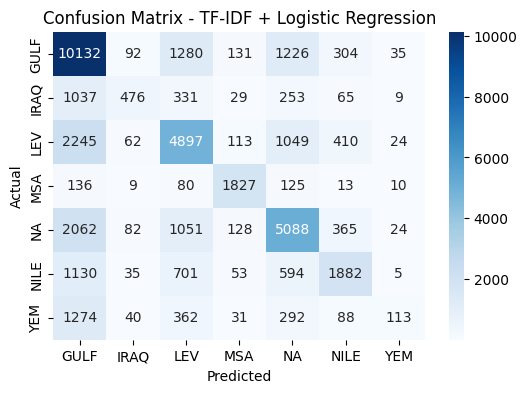

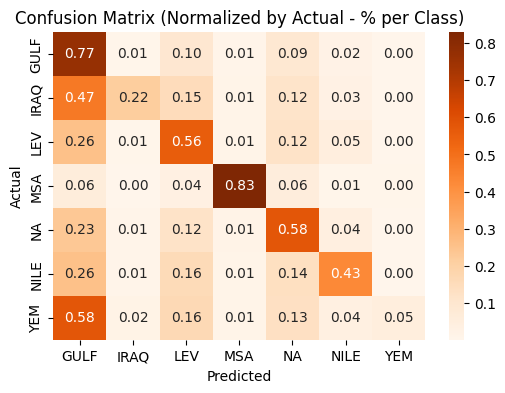

In [14]:
cm = confusion_matrix(y1_test, y_pred, labels=lr_model.classes_)

# Define consistent labels
labels = sorted(df_country_sampled['Region'].unique())


cm_counts = confusion_matrix(y1_test, y_pred, labels=labels)

# Normalized confusion matrix (percent per row)
cm_percent = cm_counts.astype('float') / cm_counts.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

# --- Plot row-normalized percentages ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Normalized by Actual - % per Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model 1 (balanced)

In [15]:
print(df_region_sampled['Region'].value_counts())

Region
GULF    11000
IRAQ    11000
LEV     11000
MSA     11000
NA      11000
NILE    11000
YEM     11000
Name: count, dtype: int64


In [16]:
x_balanced = df_region_sampled['text']
y_balanced = df_region_sampled['Region']

x2_train, x2_test, y2_train, y2_test = train_test_split(
    x_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

### TF-IDF Vectorization

In [17]:
X_train_tfidf = vectorizer.fit_transform(x2_train)
X_test_tfidf = vectorizer.transform(x2_test)

### Train Logistical Regression

In [18]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y2_train)


LogisticRegression(max_iter=1000)

In [19]:
y_pred = lr_model.predict(X_test_tfidf)

print("TF-IDF + Logistic Regression (Balanced) Classification Report:\n")
print(classification_report(y2_test, y_pred))


TF-IDF + Logistic Regression (Balanced) Classification Report:

              precision    recall  f1-score   support

        GULF       0.42      0.44      0.43      2200
        IRAQ       0.54      0.55      0.54      2200
         LEV       0.48      0.46      0.47      2200
         MSA       0.80      0.90      0.85      2200
          NA       0.52      0.51      0.52      2200
        NILE       0.56      0.58      0.57      2200
         YEM       0.41      0.35      0.38      2200

    accuracy                           0.54     15400
   macro avg       0.53      0.54      0.54     15400
weighted avg       0.53      0.54      0.54     15400



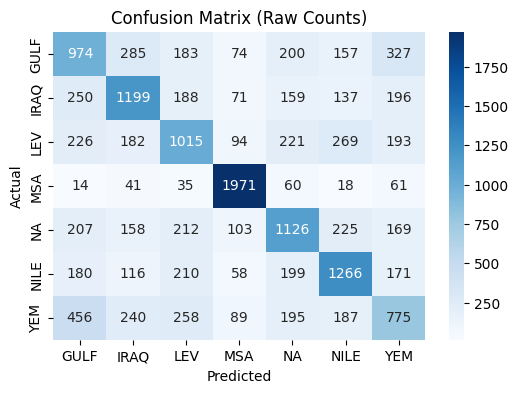

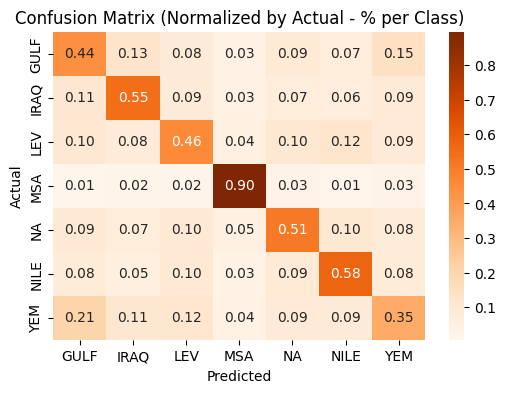

In [20]:
# Define consistent labels
labels = sorted(df_region_sampled['Region'].unique())

# Raw confusion matrix (counts)
cm_counts = confusion_matrix(y2_test, y_pred, labels=labels)

# Normalized confusion matrix (percent per row)
cm_percent = cm_counts.astype('float') / cm_counts.sum(axis=1)[:, np.newaxis]

# --- Plot raw counts ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Plot row-normalized percentages ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Normalized by Actual - % per Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Model 2: TF-IDF + SVM

In [21]:
def run_svm_model(x_train, x_test, y_train, y_test, labels, title=""):
    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), analyzer='char_wb')
    X_train_tfidf = vectorizer.fit_transform(x_train)
    X_test_tfidf = vectorizer.transform(x_test)

    # Train SVM model
    model = LinearSVC()
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Classification report
    print(f"\n=== {title} ===")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_percent = cm_counts.astype('float') / cm_counts.sum(axis=1)[:, np.newaxis]

    # Plot raw counts
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{title} - Confusion Matrix (Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot normalized percentages
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Oranges', xticklabels=labels, yticklabels=labels)
    plt.title(f"{title} - Confusion Matrix (Normalized %)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model, vectorizer, y_pred



=== Test 1 – TF-IDF + SVM ===
              precision    recall  f1-score   support

        GULF       0.56      0.77      0.65     13200
        IRAQ       0.68      0.16      0.26      2200
         LEV       0.56      0.55      0.56      8800
         MSA       0.77      0.86      0.81      2200
          NA       0.58      0.58      0.58      8800
        NILE       0.60      0.39      0.47      4400
         YEM       0.59      0.02      0.04      2200

    accuracy                           0.58     41800
   macro avg       0.62      0.48      0.48     41800
weighted avg       0.59      0.58      0.55     41800



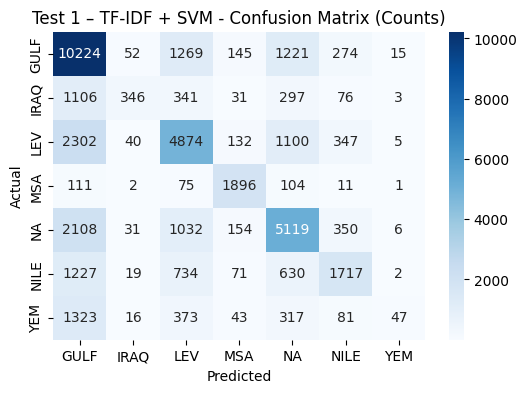

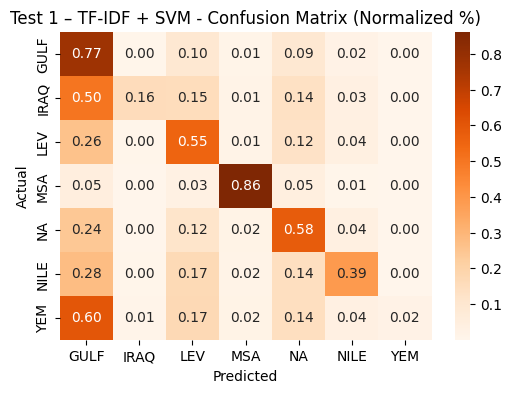

In [22]:
labels = sorted(df_country_sampled['Region'].unique())

svm_model_test1, tfidf_test1, y1_pred = run_svm_model(
    x1_train, x1_test, y1_train, y1_test,
    labels=labels,
    title="Test 1 – TF-IDF + SVM"
)


=== Test 2 – TF-IDF + SVM ===
              precision    recall  f1-score   support

        GULF       0.42      0.39      0.41      2200
        IRAQ       0.53      0.56      0.54      2200
         LEV       0.48      0.46      0.47      2200
         MSA       0.78      0.92      0.84      2200
          NA       0.52      0.53      0.52      2200
        NILE       0.55      0.60      0.57      2200
         YEM       0.43      0.32      0.37      2200

    accuracy                           0.54     15400
   macro avg       0.53      0.54      0.53     15400
weighted avg       0.53      0.54      0.53     15400



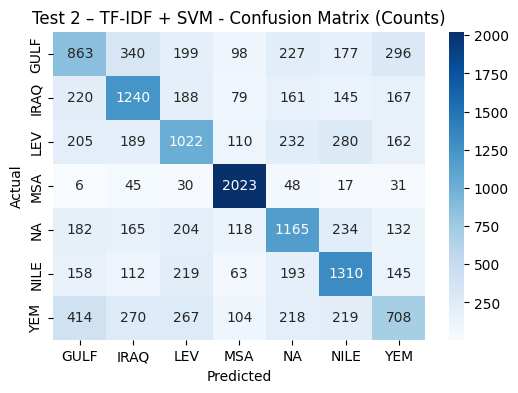

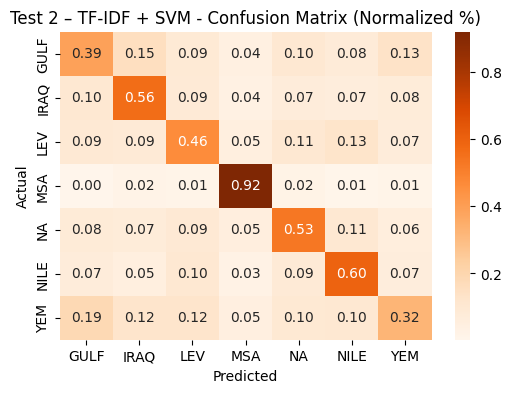

In [23]:
labels = sorted(df_region_sampled['Region'].unique())

svm_model_test2, tfidf_test2, y2_pred = run_svm_model(
    x2_train, x2_test, y2_train, y2_test,
    labels=labels,
    title="Test 2 – TF-IDF + SVM"
)

In [24]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Label encode regions
le1 = LabelEncoder()
le2 = LabelEncoder()

y1_train_enc = le1.fit_transform(y1_train)
y1_test_enc = le1.transform(y1_test)

y2_train_enc = le2.fit_transform(y2_train)
y2_test_enc = le2.transform(y2_test)

# Create HuggingFace datasets
train_dataset1 = Dataset.from_dict({'text': x1_train.tolist(), 'label': y1_train_enc})
test_dataset1 = Dataset.from_dict({'text': x1_test.tolist(), 'label': y1_test_enc})

train_dataset2 = Dataset.from_dict({'text': x2_train.tolist(), 'label': y2_train_enc})
test_dataset2 = Dataset.from_dict({'text': x2_test.tolist(), 'label': y2_test_enc})


In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

train_dataset1 = train_dataset1.map(tokenize, batched=True)
test_dataset1 = test_dataset1.map(tokenize, batched=True)

train_dataset2 = train_dataset2.map(tokenize, batched=True)
test_dataset2 = test_dataset2.map(tokenize, batched=True)


C:\Users\essah\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\essah\.cache\huggingface\hub\models--aubmindlab--bert-base-arabertv2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 15400/15400 [00:03<00:00, 3946.16 examples/s]


In [27]:
import transformers
print(transformers.__version__)


4.51.2


In [41]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model1 = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=len(le1.classes_))
model2 = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=len(le2.classes_))

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    fp16=True,
    logging_steps=500,
    report_to=None,
)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))


True
0
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [43]:
trainer1 = Trainer(
    model=model1,
    args=training_args,
    train_dataset=train_dataset1,
    eval_dataset=test_dataset1,
    tokenizer=tokenizer
)

trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset2,
    eval_dataset=test_dataset2,
    tokenizer=tokenizer
)

# Train both
trainer1.train()
trainer2.train()


C:\Users\essah\AppData\Local\Temp\ipykernel_18908\1795884016.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(
C:\Users\essah\AppData\Local\Temp\ipykernel_18908\1795884016.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


Step,Training Loss
500,1.306000
1000,1.116900
1500,1.066300
2000,1.009800
2500,1.005100
3000,0.950500
3500,0.971700
4000,0.950500
4500,0.942000
5000,0.918400


Step,Training Loss
500,1.403400
1000,1.213200
1500,1.101800
2000,1.073800
2500,1.040300
3000,1.009400
3500,1.008300
4000,0.946000
4500,0.973200
5000,0.953000


TrainOutput(global_step=7700, training_loss=1.0208534240722655, metrics={'train_runtime': 3270.7069, 'train_samples_per_second': 18.834, 'train_steps_per_second': 2.354, 'total_flos': 1.620836861952e+16, 'train_loss': 1.0208534240722655, 'epoch': 1.0})

In [44]:
from sklearn.metrics import classification_report

# Test 1
preds1 = trainer1.predict(test_dataset1)
y1_pred_labels = le1.inverse_transform(preds1.predictions.argmax(axis=1))
print("=== Test 1 – AraBERT ===")
print(classification_report(y1_test, y1_pred_labels))

# Test 2
preds2 = trainer2.predict(test_dataset2)
y2_pred_labels = le2.inverse_transform(preds2.predictions.argmax(axis=1))
print("=== Test 2 – AraBERT ===")
print(classification_report(y2_test, y2_pred_labels))


=== Test 1 – AraBERT ===
              precision    recall  f1-score   support

        GULF       0.70      0.88      0.78     13200
        IRAQ       0.76      0.50      0.60      2200
         LEV       0.76      0.73      0.74      8800
         MSA       0.92      0.98      0.95      2200
          NA       0.82      0.72      0.77      8800
        NILE       0.74      0.73      0.73      4400
         YEM       0.64      0.23      0.34      2200

    accuracy                           0.75     41800
   macro avg       0.76      0.68      0.70     41800
weighted avg       0.75      0.75      0.74     41800



=== Test 2 – AraBERT ===
              precision    recall  f1-score   support

        GULF       0.54      0.54      0.54      2200
        IRAQ       0.70      0.67      0.68      2200
         LEV       0.65      0.69      0.67      2200
         MSA       0.94      0.98      0.96      2200
          NA       0.79      0.63      0.70      2200
        NILE       0.75      0.75      0.75      2200
         YEM       0.49      0.56      0.53      2200

    accuracy                           0.69     15400
   macro avg       0.69      0.69      0.69     15400
weighted avg       0.69      0.69      0.69     15400

